In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [2]:
df = pd.read_csv("/Users/r3alistic/Programming/CoffeeCV/features_v2.csv")
df.head()

,onset_time_s,continuity,mean_width,cv_width,amp_width,slope_width,jitter_cx,delta_val,delta_hue,flicker,label_rule_based,pull_duration_s,true_label,frame_folder
0,0.033333,0.992823,38.191387,0.271673,49.0,0.059983,154.437988,25.0,5.5,6.0,underextracted,30.72,good,frames_good_pulls/vid_100_good
1,0.033333,0.997608,24.657894,0.338018,32.0,-0.009234,155.832611,29.0,6.0,2.0,underextracted,30.05,good,frames_good_pulls/vid_102_good
2,0.016667,0.997613,36.463009,0.250612,44.0,0.015607,172.412918,26.0,5.0,2.0,underextracted,29.32,good,frames_good_pulls/vid_105_good
3,0.016667,0.985680,21.544153,0.241984,27.0,-0.023103,169.787109,22.0,5.0,12.0,underextracted,30.02,good,frames_good_pulls/vid_108_good
4,0.016667,0.894988,19.821003,0.319346,34.0,-0.025514,70.975861,9.0,2.5,79.0,underextracted,27.55,good,frames_good_pulls/vid_112_good


In [3]:
df.shape

(113, 14)

Right now there are no missing values, but just drop them if there are.

In [4]:
df.dropna(axis=0,inplace=True)

In [5]:
df.isna().sum().sum()

0

Now just for sanity, check for duplicates

In [7]:
len(df["frame_folder"]) == len(set(df["frame_folder"]))

True

# Summary Statistics

In [8]:
df.describe()

,onset_time_s,continuity,mean_width,cv_width,amp_width,slope_width,jitter_cx,delta_val,delta_hue,flicker,pull_duration_s
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,0.055752,0.855603,29.294070,0.617632,60.194690,-0.040980,133.825503,8.981195,2.871681,29.734513,27.938938
std,0.193531,0.242089,21.135160,0.940098,45.966381,0.065937,63.976918,19.011563,2.235847,38.085903,5.578552
min,0.016667,0.004773,0.210024,0.147891,13.000000,-0.311933,5.192918,-53.000000,-1.000000,0.000000,8.640000
25%,0.016667,0.861111,17.577566,0.271673,32.000000,-0.057403,98.454391,-3.000000,1.000000,1.000000,26.020000
50%,0.016667,0.968974,25.525059,0.363442,44.000000,-0.023537,131.028778,5.875000,3.000000,12.000000,29.370000
75%,0.016667,0.997613,35.666668,0.576087,69.000000,-0.002801,160.029770,22.000000,4.000000,55.000000,30.840000
max,1.866667,1.000000,120.109787,8.436661,252.000000,0.085365,327.269501,61.000000,8.500000,152.000000,46.540000


In [14]:
def aggregate_mean(df,features):
    return df.groupby(by=["true_label"])[features].mean()

def aggregate_median(df,features):
    return df.groupby(by=["true_label"])[features].median()

In [19]:
aggregate_mean(df,["continuity","delta_val","jitter_cx","delta_hue","delta_val","pull_duration_s"])

,continuity,delta_val,jitter_cx,delta_hue,delta_val,pull_duration_s
true_label,,,,,,
good,0.908683,12.324675,139.876639,3.590909,12.324675,28.090260
under,0.742071,1.829861,120.882797,1.333333,1.829861,27.615278


What do these tell me? The good thing is that if we are looking at the mean, then our numeric features have a stark contrast. However, there are way less underextracted than good videos, so let's check median

In [20]:
aggregate_median(df,["continuity","delta_val","jitter_cx","delta_hue","delta_val","pull_duration_s"])

,continuity,delta_val,jitter_cx,delta_hue,delta_val,pull_duration_s
true_label,,,,,,
good,0.978520,9.0,133.27739,3.5,9.0,29.40
under,0.894988,3.5,126.28075,1.0,3.5,28.64


Out of all of these, continuity and pull duration might not be worthy features

# Data Preprocessing + Model Building --> Pipeline

(Even with an abysmally low amount of data)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

First we will try <u>Logistic Regression</u>

In [28]:
# Separate features and target
X = df.drop(columns=["true_label", "label_rule_based","frame_folder"])
y = df["true_label"].to_numpy()

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

predictors_num = list(X.columns)

preprocessor = ColumnTransformer([
    ("scaler",StandardScaler(),predictors_num),
],remainder="drop") #keep "drop". This column transformer will only affect X

# Encode target labels as integers (ex: good = 0, under = 1). OneHotEncoder would be too much here. Just labels in the same column is fine
#pipeline .fit and .predict calls know to do fit_transform on train data and just .transform on test data and unseen data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded)

#Using a pipeline no matter what. When we save the best one with joblib, it will have all the preprocessing built into it.
pipeline_1 = Pipeline([
    ("preprocessor",preprocessor),
    ("classifier",LogisticRegression(class_weight='balanced'))
])

#y_test is encoded for future reference testing
pipeline_1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['onset_time_s', 'continuity',
                                                   'mean_width', 'cv_width',
                                                   'amp_width', 'slope_width',
                                                   'jitter_cx', 'delta_val',
                                                   'delta_hue', 'flicker',
                                                   'pull_duration_s'])])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [40]:
y_pred_1 = pipeline_1.predict(X_test)

# Validation Strategies

In [41]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score

## Training Scores - Model 1

In [42]:
y_pred_train_1 = pipeline_1.predict(X_train)

**TPR = Recall = Sensitivity = TP / (TP + FN)**
* "Of all the actually positive cases, how many did we get correct"?
    * True Positive Rate

**Precision = TP / (TP + FP)**
* "Of all of the things the model predicted as positive cases, how many were actually positive?"
    * Positive Predicted Value

In [43]:
print(classification_report(y_train,y_pred_train_1))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        54
           1       0.68      0.88      0.77        17

    accuracy                           0.87        71
   macro avg       0.82      0.88      0.84        71
weighted avg       0.89      0.87      0.88        71



In [44]:
print("LogReg's Accuracy Score (Training):",accuracy_score(y_train,y_pred_train_1))

LogReg's Accuracy Score (Training): 0.8732394366197183


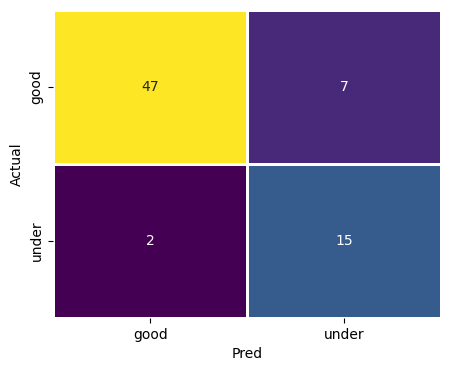

In [45]:
cm = confusion_matrix(y_train,y_pred_train_1)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,cmap="viridis",linewidth=0.85,xticklabels=encoder.classes_, yticklabels=encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

In [46]:
cv_scores = cross_val_score(pipeline_1,X_train,y_train,cv=5,scoring="accuracy")
print(sorted(cv_scores))
print("mean",cv_scores.mean())

[0.6428571428571429, 0.7142857142857143, 0.7142857142857143, 0.8, 0.8571428571428571]
mean 0.7457142857142858


## Testing Scores - Model 1

In [47]:
print(classification_report(y_test,y_pred_1))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.25      0.25      0.25         4

    accuracy                           0.67        18
   macro avg       0.52      0.52      0.52        18
weighted avg       0.67      0.67      0.67        18



In [48]:
print("LogReg's Accuracy Score:",accuracy_score(y_test,y_pred_1))

LogReg's Accuracy Score: 0.6666666666666666


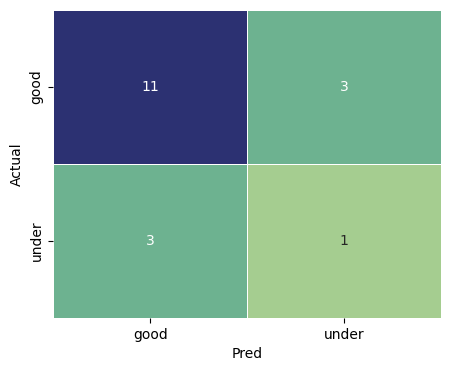

In [49]:
cm = confusion_matrix(y_test,y_pred_1)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,cmap="crest",linewidth=0.5,xticklabels=encoder.classes_, yticklabels=encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

<p style="color:lightpink">So far, what are the notable feats: 90% train accuracy, more incorrect estimates than we'd like, solid preprocessing, but the model will overfit without enough data. <u>What we need to keep in mind is that training score DOWN and testing score UP is fine and actually what we want anyway.</u></p>

# Feature Selection and Optimization

In [51]:
feature_importance = pipeline_1.named_steps['classifier'].coef_[0]
feature_names = predictors_num
importance_df = pd.DataFrame({'feature': feature_names, 'importance': abs(feature_importance)})
importance_df.sort_values('importance', ascending=False)

,feature,importance
11,overall_steadiness,1.177387
5,flow_steadiness,0.973707
7,flow_trend,0.937449
9,brightness_acceleration,0.886954
8,brightness_momentum,0.866563
2,color_consistency,0.765468
4,color_change_rate,0.497809
10,brightness_trend,0.482301
1,color_progression,0.419807
12,phase_uniformity,0.326297


The above values are the absolute slope coefficients for the decision boundary

In [52]:
df["Category"].value_counts()

Category
good     68
under    21
Name: count, dtype: int64